# 深度学习实验五:循环神经网络编程

本次实验练习使用torch.nn中的类设计一个循环神经网络进行MNIST图像分类。

在本次实验中，你要设计一个CNN，用于将$28 \times 28$的MNIST图像转换为$M\times M\times D$的特征图，将该特征图看作是一个长度为$M\times M$的特征序列，序列中每一个特征向量的大小为$D$，然后使用RNN对该序列分类。

In [247]:
name = '王浩南'#填写你的姓名
sid = 'E02014154'#填写你的学号

print('姓名:%s, 学号:%s'%(name, sid))

姓名:王浩南, 学号:E02014154


In [248]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 1. 准备数据

In [249]:
from torchvision import datasets,transforms

In [250]:
#定义变换
#一行代码，提示:transforms.Compose()函数
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [251]:
data_path = '../data/'
MNIST_train = datasets.MNIST(data_path,download=True,train = True,transform = transform)
MNIST_test =  datasets.MNIST(data_path,download=True,train = False,transform = transform)

In [252]:
MNIST_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

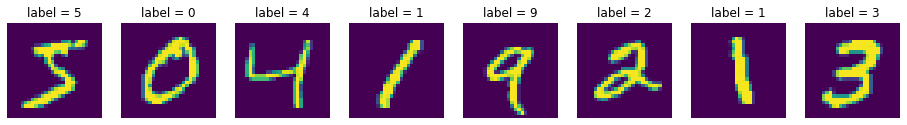

In [253]:
#显示图像样本
cifar10_iter = iter(MNIST_train)
plt.figure(figsize = [16,10])
for i in range(8):
    im,label = next(cifar10_iter)
    im = (im.permute((1,2,0))+1)/2
    plt.subplot(1,8,i+1)
    plt.imshow(im)
    plt.title('label = %d'%(label))
    plt.axis('off')
    
plt.show()

# 2. 设计CNN类

从torch.nn.Module派生一个子类CNN，表示一个卷积神经网络;用于将 MNIST 图像转换为一个𝑀×𝑀×𝐷 的特征图

In [254]:
#在下面添加代码，实现一个CNN,用于提取图像特征
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # 定义卷积层1，输入通道数为1，输出通道数为16，卷积核大小为3x3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        # 定义批量归一化层1
        self.bn1 = nn.BatchNorm2d(num_features=16)
        # 定义激活函数
        self.act1 = nn.ReLU()
        # 定义池化层1，池化核大小为2x2
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        # 定义卷积层2，输入通道数为16，输出通道数为32，卷积核大小为3x3
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        # 定义批量归一化层2
        self.bn2 = nn.BatchNorm2d(num_features=32)
        # 定义激活函数
        self.act2 = nn.ReLU()
        # 定义池化层2，池化核大小为2x2
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # 定义跳跃连接
        self.residual = nn.Sequential(
            # 定义卷积层3，输入通道数为32，输出通道数为32，卷积核大小为3x3
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            # 定        nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            # 定义卷积层4，输入通道数为32，输出通道数为32，卷积核大小为3x3
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(num_features=32)
        )
    
        # 定义全连接层1
        self.fc1 = nn.Linear(in_features=8*10*10, out_features=64)
        # 定义全连接层2，输入神经元数为64，输出神经元数为10（因为MNIST数据集的输出类别为10个数字）
        self.fc2 = nn.Linear(in_features=64, out_features=10)
    
    def forward(self, x):
        # 前向传播流程
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        # 跳跃连接的前向传播
        residual = self.residual(x)
        # 将输入x与跳跃连接的输出相加
        x = x + residual
        
        # 将二维特征图展平成一维向量
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [255]:
#测试CNN类
X = torch.rand((5,1,28,28),dtype = torch.float32)
net = CNN()
Y = net(X)
print(Y.shape)

torch.Size([5, 10])


In [256]:
#输出模型
print(net)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (residual): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=800, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [257]:
%pip install -i https://pypi.tuna.tsinghua.edu.cn/simple torchsummary

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [258]:
from torchsummary import summary

summary(net.cuda(), input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
         MaxPool2d-4           [-1, 16, 13, 13]               0
            Conv2d-5           [-1, 32, 11, 11]           4,640
       BatchNorm2d-6           [-1, 32, 11, 11]              64
              ReLU-7           [-1, 32, 11, 11]               0
         MaxPool2d-8             [-1, 32, 5, 5]               0
            Conv2d-9             [-1, 32, 3, 3]           9,248
             ReLU-10             [-1, 32, 3, 3]               0
           Conv2d-11             [-1, 32, 1, 1]           9,248
      BatchNorm2d-12             [-1, 32, 1, 1]              64
           Linear-13                   [-1, 64]          51,264
           Linear-14                   

# 3. 设计分类模型

在分类模型中，使用上面定义的CNN作为特征提取器，用LSTM循环网络构造分类器。你的模型中应该包含一个CNN和一个RNN。


In [259]:
#在下面添加代码，实现一个Classifier类，用CNN和LSTM循环网络构造分类器
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(Classifier, self).__init__()
        self.cnn = CNN()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size(0), -1, out.size(1))
        out, _ = self.rnn(out)
        out = self.fc(out[:, -1, :])
        return out

In [260]:
#测试上面的类
model = Classifier(input_size=10, hidden_size=128, num_layers=1, num_classes=10)#一行代码
X = torch.randn(5,1,28,28)
Y = model(X)
print(Y.shape)

torch.Size([5, 10])


# 4.训练模型

# 4.1 第一步，构造加载器，用于加载上面定义的数据集

In [261]:
train_loader = torch.utils.data.DataLoader(MNIST_train, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(MNIST_test, batch_size = 32, shuffle = False)

In [262]:
imgs,labels = next(iter(train_loader))

In [263]:
imgs.shape

torch.Size([32, 1, 28, 28])

In [264]:
labels.shape

torch.Size([32])

# 4.2 第二步，训练模型

注意：训练卷积神经网络时，网络的输入是四维张量，尺寸为$N\times C \times H \times W$，分别表示张量

In [265]:
#添加代码，完成下面的训练函数
def Train(model, loader, epochs, lr = 0.1):
    '''
    model:模型对象
    loader:数据加载器   
    '''
    epsilon = 1e-6

    #将model置于train模式
    net.train()

    #定义合适的优化器
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    
    #定义损失函数
    loss = F.cross_entropy
    
    #请在下面完成训练代码
    #请在迭代过程中每100次迭代，输出一次损失
    loss0 = 0
    for epoch in range(epochs):
        for it,(imgs, labels) in enumerate(loader):
            #1. zero_grads
            #请用一行代码实现
            optimizer.zero_grad()
            imgs, labels = imgs.cuda(), labels.cuda()

            #2. F.P.前向传播
            #请用一行代码实现
            logits = model(imgs)

            #3. 计算损失            
            loss1 = loss(logits, labels)
            
            if(abs(loss1.item() - loss0)<epsilon):
                break
                
            loss0 = loss1.item()
                
            if it%100==0:
                print('epoch %d, iter %d, loss = %f\n'%(epoch,it,loss1.item()))
                
            #4. 后向传播
            #请用一行代码实现
            loss1.backward()
            
            #5. 梯度下降
            #请用一行代码实现.
            optimizer.step()    
    return model          


In [266]:
#构造并训练模型
model = Classifier(input_size=10, hidden_size=128, num_layers=1, num_classes=10)
model = model.cuda()
model = Train(model, test_loader, 20)

epoch 0, iter 0, loss = 2.316965

epoch 0, iter 100, loss = 2.262871

epoch 0, iter 200, loss = 2.078416

epoch 0, iter 300, loss = 1.565925

epoch 1, iter 0, loss = 1.455163

epoch 1, iter 100, loss = 0.905373

epoch 1, iter 200, loss = 0.495477

epoch 1, iter 300, loss = 0.312206

epoch 2, iter 0, loss = 0.408765

epoch 2, iter 100, loss = 0.503093

epoch 2, iter 200, loss = 0.128072

epoch 2, iter 300, loss = 0.092336

epoch 3, iter 0, loss = 0.177374

epoch 3, iter 100, loss = 0.327589

epoch 3, iter 200, loss = 0.069116

epoch 3, iter 300, loss = 0.046908

epoch 4, iter 0, loss = 0.190766

epoch 4, iter 100, loss = 0.159573

epoch 4, iter 200, loss = 0.049512

epoch 4, iter 300, loss = 0.079523

epoch 5, iter 0, loss = 0.137959

epoch 5, iter 100, loss = 0.166230

epoch 5, iter 200, loss = 0.071486

epoch 5, iter 300, loss = 0.019617

epoch 6, iter 0, loss = 0.048092

epoch 6, iter 100, loss = 0.127029

epoch 6, iter 200, loss = 0.044633

epoch 6, iter 300, loss = 0.013822

epoch 

# 4.3 第三步，测试模型

In [267]:
#编写模型测试过程
def Evaluate(model, loader):
    model.eval()
    correct = 0
    counts = 0
    for imgs, labels in loader:
        imgs, labels = imgs.cuda(), labels.cuda()
        logits = model(imgs)
        yhat = logits.argmax(dim = 1)
        correct = correct + (yhat==labels).sum().item()
        counts = counts + imgs.size(0)
    
    accuracy = correct / counts
    
    return accuracy

In [268]:
acc = Evaluate(model,test_loader)
print('Accuracy = %0.3f'%(acc))

Accuracy = 0.997


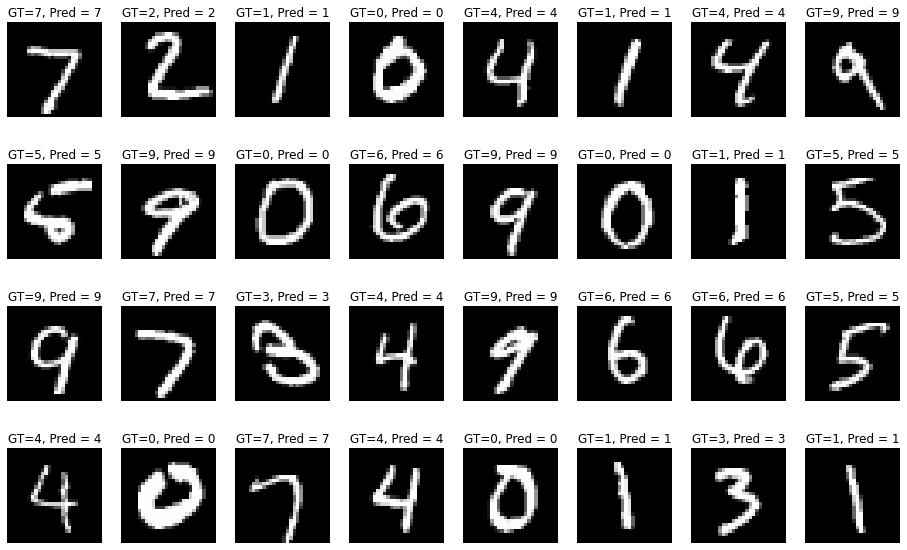

In [269]:
imgs,labels  = next(iter(test_loader))
imgs, labels = imgs.cuda(), labels.cuda()

logits = model(imgs)

imgs, labels = imgs.cpu(), labels.cpu()

yhat = logits.argmax(dim = 1)

plt.figure(figsize = (16,10))
for i in range(imgs.size(0)):
    plt.subplot(4,8,i+1)
    plt.imshow(imgs[i].squeeze()/2+0.5,cmap = 'gray')
    plt.axis('off')
    plt.title('GT=%d, Pred = %d'%(labels[i],yhat[i]))
    
plt.show()